![title](./img/Header.jpg)

<h1><center>Covid-19 Tweet Clustering </center></h1>



## Indíce
* [Introducción: Presentación del proyecto](#sarrera)
* [Datos](#datuak)
* [Data pre-processing](#dpr)
    * [Visualización de los datos](#ikuskapena)
    * [Adaptación de los datos](#moldaketa)
* [Exploratory Data Analysis](#exploratory)
* [K-Means Algorithm](#kmeans)
* [Inferencia del Algoritmo](#kmeans)


# Introducción: Presentación del proyecto <a name="sarrera"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msg
import string
import re
import nltk
from scipy import spatial
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from sklearn import preprocessing
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from scipy.spatial import distance
from imageio import imread
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import random
import math
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import gensim

<hr>

# Datos <a name="datuak"></a>

In [110]:
df = pd.read_csv("./Corona_NLP.csv", engine='python')

In [81]:
df.drop(columns={'UserName','ScreenName','Location','TweetAt'},axis=1,inplace=True)
df

OriginalTweet           Sentiment
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      advice Talk to your neighbours family to excha...            Positive
2      Coronavirus Australia: Woolworths to give elde...            Positive
3      My food stock is not the only one which is emp...            Positive
4      Me, ready to go at supermarket during the #COV...  Extremely Negative
...                                                  ...                 ...
41152  Airline pilots offering to stock supermarket s...             Neutral
41153  Response to complaint not provided citing COVI...  Extremely Negative
41154  You know it��s getting tough when @KameronWild...            Positive
41155  Is it wrong that the smell of hand sanitizer i...             Neutral
41156  @TartiiCat Well new/used Rift S are going for ...            Negative

[41157 rows x 2 columns]

<hr>

# Data pre-processing <a name="dpr"></a>

## Visualización de los datos <a name="ikuskapena"></a>

Primero, vamos a mirar los datos para tratar los valores nulos

In [82]:
missing_data = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


<AxesSubplot:>

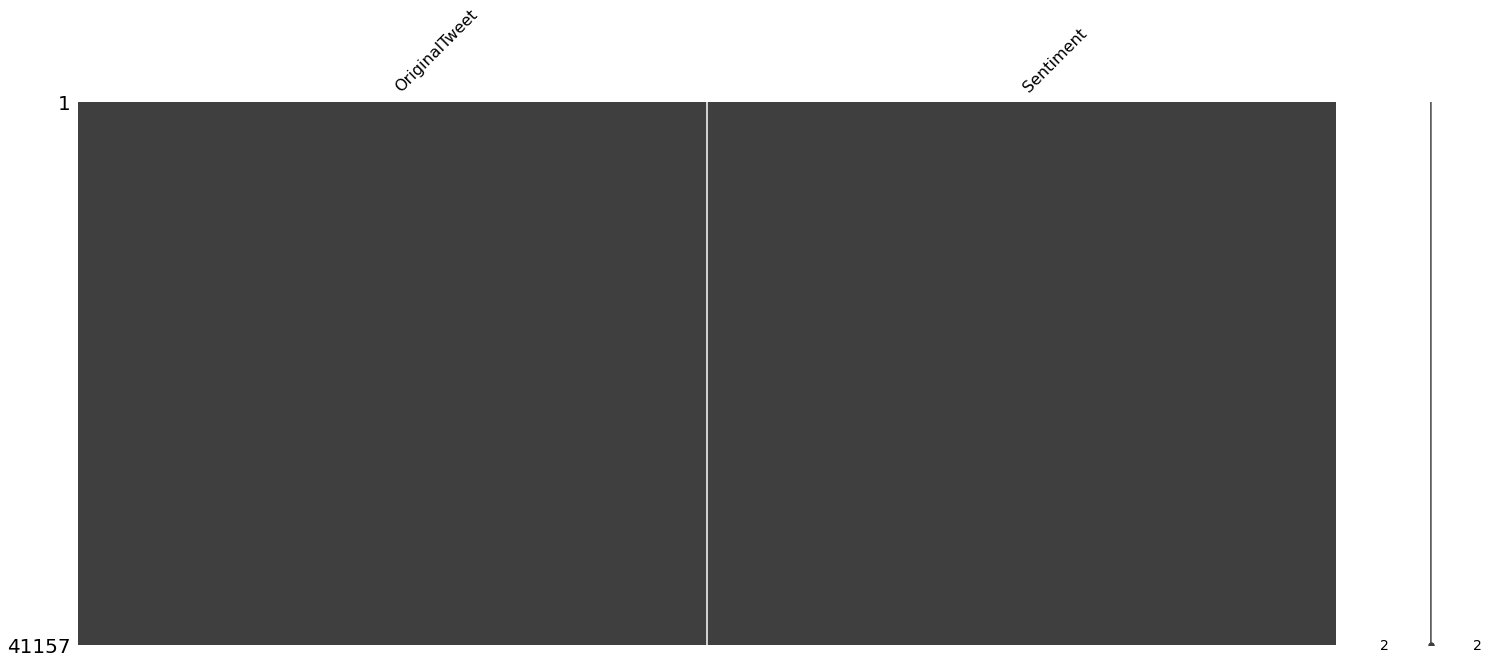

In [83]:
msg.matrix(df)

Como se puede apreciar, no encontramos ninguna entidad con un valor NaN

## Adaptación de los datos<a name="moldaketa"></a>
### Hemos dividido el preprocessing en diez pasos diferentes:
1. Borrar las URL
2. Transformar los emoticonos
3. Transformar los emojis
4. Transformar las abreviaciones
5. Pasar todo a minúsculas
6. Quitar los stopwords
7. Quitar las marcas de puntuacion
8. Corregir palabras
9. Lemmanization
10. Corregir palabras

### 1.Borrar las URL
En los tweets podemos encontrar URL-s las cuales no no son de utilidad. Es por ello que vamos a eliminarlas.

 <img src="./media/linkCase.png" alt="drawing" width="600"/>

In [28]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_urls(text))

### 2. Transformar los emoticonos
Debajo tenemos comprimida toda la lista de emoticonos: https://unicode.org/emoji/charts/full-emoji-list.html , no nos interesa eliminarnos, ya que pueden incluir información del contexto.


 <img src="./media/emotiCase.png" alt="drawing" width="600"/>

In [29]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(
            r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",", "").replace(":", "").split()), text)
    return text

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(
    lambda text: convert_emojis(text))

### 3. Transformar los emojis
Vamos a cambiar los emojis tambien. https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py

 <img src="./media/emojiCase.png" alt="drawing" width="600"/>

In [30]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: convert_emoticons(text))

### 4. Transformar las abreviaciones
Es muy común que en redes sociales, sobretodo en la habla inglesa, se utilicen abreviacionen. Estas pueden ofrecernos informacion interesante, es por ello que vmaos a transformarlas a frases hechas.
BRB = Be right back
CYA = See you later

In [29]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [30]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

### 5. Pasar todo a minusculas

Para que sea mas sencillo el procesamiento del texto, vamos a trasnformar todas las frases a minusculas.

In [31]:
df["OriginalTweet"] = df["OriginalTweet"].str.lower()

### 6. Quitar los stopwords

Las conocidas como "palabras vacias" son aquellas que no nos van a aportar ninguna información, es por ello que vamos a eliminaras.


In [88]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [31]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))

### 7. Quitar las marcas de puntuacion

Las marcas de puntuación no son relevantes, por tanto vamos a eliminarlo.

In [36]:
print(df["OriginalTweet"][12])

#horningsea caring community. let��s look less capable village ensure stay healthy. bringing shopping doors, help online shopping self isolation symptoms exposed somebody has.


In [32]:
def remove_punctuation(text:str):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    PUNCT_TO_REMOVE += 'â’'
    spaces = ''
    for i in range(len(PUNCT_TO_REMOVE)):
        spaces += ' '
    return text.translate(bytes.maketrans(PUNCT_TO_REMOVE, spaces))


In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_punctuation(text))

In [38]:
print(df["OriginalTweet"][12])

 horningsea caring community  let��s look less capable village ensure stay healthy  bringing shopping doors  help online shopping self isolation symptoms exposed somebody has 


### 8. Corregir las palabras

In [39]:
df['OriginalTweet'] = df['OriginalTweet'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [40]:
print(df["OriginalTweet"][12])

 horningsea caring community  lets look less capable village ensure stay healthy  bringing shopping doors  help online shopping self isolation symptoms exposed somebody has 




Puede ocurrir que algunas palabras esten mal escritas, es por eso que las vamos a corregir


In [41]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

### 9. Lemmanization

En este proceso, lemmanizamos las palabras, lo cual trata de eliminar las posibles conjugaciones. Mas información en el siguiente link: https://en.wikipedia.org/wiki/Lemmatisation

In [23]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: lemmatize_words(text))

### 10. Corregir palabras

Es posible que despues de todo este proceso, algunas palabras se hayan "corrompido", es por eso que vamos a volver a corregirlas.

In [25]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [26]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

In [27]:
df.to_csv("../csv/data_preprocess.csv", index=False)

<hr>

# Exploratory Data Analisis <a name="exploratory"></a>

Vamos a utilizar esta sección para analizar los datos y ver si podemos extraer algo de información relevante de esta.

### Datos estadisticos
Vamos a analizar los datos estadísticos, para comprobar si podemos extraer alguna información relevante del conjunto de datos.

In [67]:
df = pd.read_csv("moritz.csv")
df = df.head(200)
df.drop(columns=["OriginalTweet", "CleanOriginalTweet"],inplace=True)
y = df['label']
df = df.iloc[: , 1:]

Los diferentes valores de la clase y sus frecuencias

<AxesSubplot:>

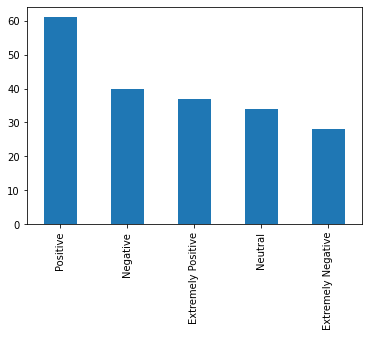

In [68]:
df['label'].value_counts().plot(kind='bar')

In [69]:
df['label'].describe()


count          200
unique           5
top       Positive
freq            61
Name: label, dtype: object

In [70]:
df.drop("label",axis=1,inplace=True)

### Palabras mas utillizadas

In [72]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u') #Konponketa 'u' hitza kontuan ez izateko.
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(STOPWORDS)])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))
df['OriginalTweet'] = df['OriginalTweet'].replace({'couid': 'covid'}, regex=True) #Esta transormacion no es valida.
df['OriginalTweet'] = df['OriginalTweet'].replace({'amp': ' '}, regex=True) #& Otro caso de error


NameError: name 'stopwords' is not defined

In [59]:
cnt = Counter()
for text in df["OriginalTweet"].values:
    for word in text.split():
        cnt[word] += 1  
cnt.most_common(30)

[('covid', 22196),
 ('coronavirus', 18207),
 ('price', 9036),
 ('store', 8306),
 ('supermarket', 7827),
 ('food', 7400),
 ('grocery', 6790),
 ('people', 5653),
 ('consumer', 5346),
 ('shopping', 3629),
 ('online', 3468),
 ('pandemic', 3254),
 ('need', 3239),
 ('time', 3204),
 ('get', 3075),
 ('worker', 2928),
 ('sanitizer', 2900),
 ('hand', 2695),
 ('panic', 2612),
 ('go', 2556),
 ('home', 2493),
 ('like', 2402),
 ('demand', 2367),
 ('help', 2269),
 ('stock', 2243),
 ('one', 2141),
 ('supply', 2000),
 ('day', 1982),
 ('going', 1959),
 ('work', 1876)]

### Word cloud

In [61]:
df_negative = df[df["label"]=="Negative"] #Dataframes dependiendo de la clase
df_neutral = df[df["label"]=="Neutral"]
df_positive = df[df["label"]=="Positive"]
df_extremely_positive = df[df["label"]=="Extremely Positive"]
df_extremely_negative = df[df["label"]=="Extremely Negative"]
df

Unnamed: 0  \
0               0   
1               1   
2               2   
3               3   
4               4   
...           ...   
41152       41152   
41153       41153   
41154       41154   
41155       41155   
41156       41156   

                                                                                                                                                                                   OriginalTweet  \
0                                                                                                                                                                      menyrbie phil gaan christ   
1      advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist go set online shopping account po adequate supply regular med order   
2                                                                                              coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid outbreak   
3                        food stock one empty please panic enough food everyone take need stay calm stay safe covidfrance covid covid coronavirus confinement confinementotal confinementgeneral   
4           ready go supermarket covid outbreak paranoid food stock literaly empty coronavirus serious thing please panic cause shortage coronavirusfrance restezchezvous stayathome confinement   
...                                                                                                                                                                                          ...   
41152                                                                                                                              airline pilot offering stock supermarket shelf lockdown covid   
41153                                                                                     response complaint provided citing covid related delay yet prompt rejecting policy consumer tat way go   
41154                                                                                     know getting tough kameronwilds rationing toilet paper coronavirus toiletpaper roger martinsville help   
41155                                                                                                                     wrong smell hand sanitizer starting turn coronavirus covid coronavirus   
41156                                   tartiicat well new used rift going amazon although normal market price usually price really crazy right headset since alex announced worse covid whether   

                    label  
0                 Neutral  
1                Positive  
2                Positive  
3                Positive  
4      Extremely Negative  
...                   ...  
41152             Neutral  
41153  Extremely Negative  
41154            Positive  
41155             Neutral  
41156            Negative  

[41157 rows x 3 columns]

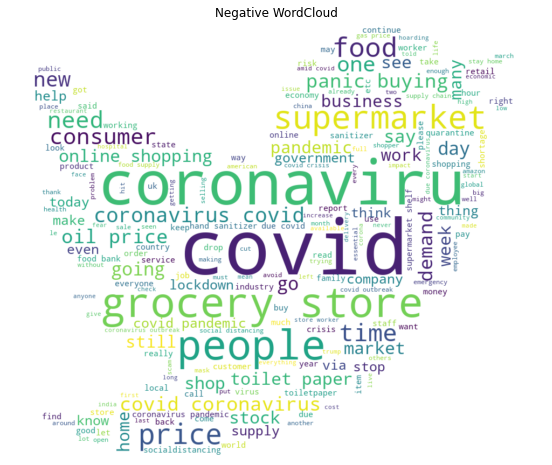

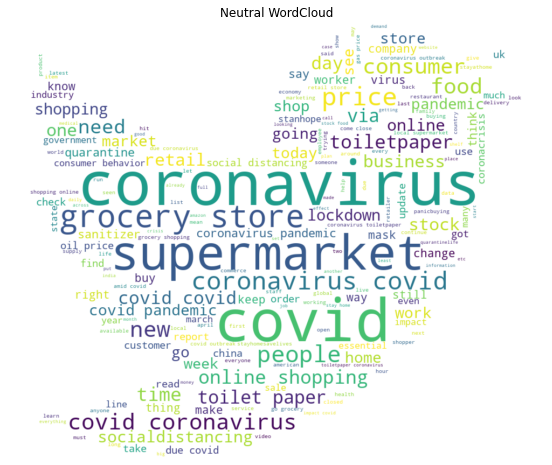

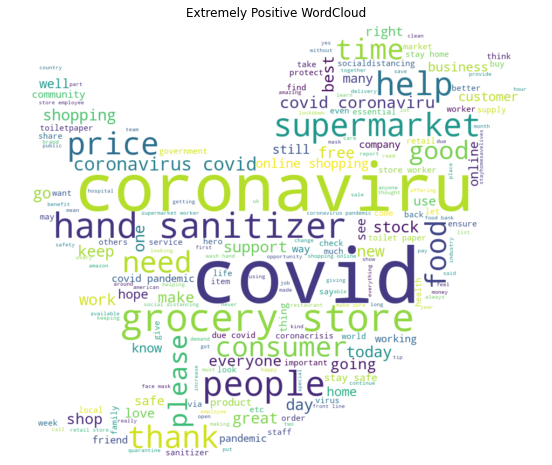

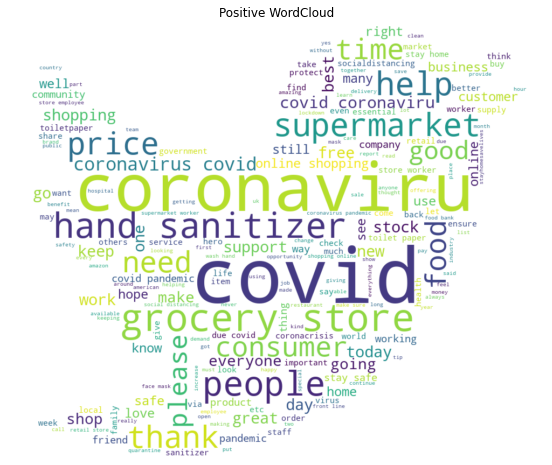

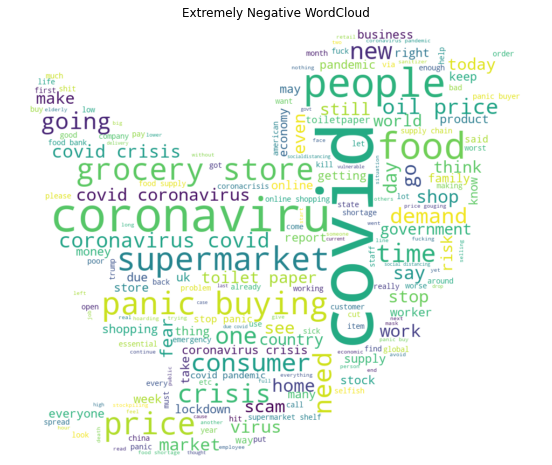

In [62]:
twitter_mask = imread('./media/twitter_mask.png')

wc_negative = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_negative['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_negative, interpolation='bilinear')
plt.title("Negative WordCloud")
plt.axis("off")
    
wc_neutral = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_neutral['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.title("Neutral WordCloud")
plt.axis("off")

wc_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_extremely_positive['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Extremely Positive WordCloud")
plt.axis("off")
plt.show()


wc_extremely_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_positive['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Positive WordCloud")
plt.axis("off")
plt.show()


wc_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_extremely_negative['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Extremely Negative WordCloud")
plt.axis("off")
plt.show()


<hr>

# Document Embedding

En el proyecto del año pasado, decidimos hacer TF-IDF, este año, hemos decidido ir un paso mas adelante, utilizando Document Embedding.

In [93]:
df = pd.read_csv("dummy_csv.csv")
# df = df.head(200)
# df.drop(columns=["OriginalTweet", "CleanOriginalTweet"],inplace=True)
# y = df['label']
# df.drop("label",axis=1,inplace=True)
# df = df.iloc[: , 1:]

0         1         2         3         4         5         6  \
0    0.000383  0.000158 -0.000949  0.000490  0.000481 -0.000549 -0.000422   
1    0.081156  0.012583  0.065316 -0.048686  0.020118  0.000674  0.011840   
2    0.076357  0.042269  0.053119  0.071835  0.035375 -0.043499  0.042177   
3    0.038704  0.027904 -0.016752  0.038551  0.041829 -0.047390 -0.000527   
4   -0.049901 -0.040428 -0.066080  0.037030  0.022905 -0.027634 -0.019163   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.020300  0.025977  0.039574  0.011304  0.000703  0.023311 -0.015562   
196  0.037390  0.013693  0.060709  0.022433 -0.045081 -0.108795  0.011544   
197  0.045157  0.050421  0.032124  0.052485  0.039181 -0.003852  0.000064   
198  0.092874  0.035942  0.074217  0.008098  0.033365  0.020711 -0.024774   
199  0.046270 -0.010605  0.057641  0.015268  0.039404  0.005764  0.032660   

            7         8         9  ...       190       191       192  \
0    0.000336  0.000962 -0.000839  ...  0.000947 -0.000078 -0.000327   
1    0.010894 -0.011872  0.091399  ...  0.075309 -0.004857 -0.013718   
2    0.074387  0.079184 -0.004334  ...  0.070950 -0.068703  0.012759   
3    0.024806  0.054844 -0.029237  ... -0.005371 -0.035112 -0.021413   
4    0.024063 -0.028400 -0.077838  ... -0.064076  0.005548 -0.045239   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.033986 -0.000837  0.003836  ...  0.071753 -0.014785 -0.002924   
196  0.066346  0.038981  0.018255  ...  0.059304 -0.015536 -0.001386   
197  0.018438  0.022132 -0.011504  ...  0.014878 -0.026523  0.001309   
198  0.019222  0.041386  0.016379  ...  0.035686 -0.038193 -0.042895   
199  0.077203  0.037647  0.014532  ...  0.050407 -0.037701  0.022726   

          193       194       195       196       197       198       199  
0    0.000401 -0.000929 -0.000909 -0.000839  0.000481 -0.000554 -0.000584  
1   -0.104003  0.024765 -0.018291  0.029533 -0.033234  0.000034  0.010331  
2   -0.031691  0.002141 -0.008097 -0.043607 -0.022737  0.024094 -0.021620  
3   -0.025157  0.053274 -0.092598 -0.034449  0.005724  0.035747 -0.027550  
4    0.031684  0.017676 -0.052134 -0.032271 -0.062767  0.007405 -0.000203  
..        ...       ...       ...       ...       ...       ...       ...  
195 -0.051220 -0.000317 -0.027990 -0.001611 -0.016581  0.024322 -0.006191  
196 -0.036315 -0.000800  0.027836  0.000260  0.047968  0.052864  0.069476  
197 -0.027966  0.022925 -0.031922 -0.014484 -0.000380  0.031740  0.032061  
198  0.025596  0.067546 -0.028524 -0.018105 -0.026496 -0.012962  0.001182  
199 -0.059666  0.002961  0.010002 -0.015650 -0.043606 -0.031099  0.023108  

[200 rows x 200 columns]

Vamos a generar la lista de tweets del dataset

In [6]:
lista = [str(i) for i in df['OriginalTweet'].copy().array]

El formato que admite Gensim es TaggedDocummet, por tanto vamos a cambiarlo

In [7]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(lista)]

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\morit/nltk_data'
    - 'c:\\users\\morit\\anaconda3\\envs\\gurobi\\nltk_data'
    - 'c:\\users\\morit\\anaconda3\\envs\\gurobi\\share\\nltk_data'
    - 'c:\\users\\morit\\anaconda3\\envs\\gurobi\\lib\\nltk_data'
    - 'C:\\Users\\morit\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


Entrenamos el modelo

Lo de abajo pone como funciona. Como el entrenamiento demora, tenemos un fichero creado que lo carga directamente

In [67]:
model = Doc2Vec.load("doc_2vec_model") # El modelo ya esta creado, por tanto solo vamos a cargarlo

Vamos a generar el dataframe con el embedding de todas las instancias

In [68]:
df_test = pd.DataFrame(columns=list(range(200)),index=list(range(41157)))

In [69]:
tagged_df = pd.Series( (v[0] for v in tagged_data))
cosas = tagged_df.apply(model.infer_vector)

In [70]:
for i in range(df.shape[0]):
    df_test.loc[i] = pd.Series(cosas[i])

In [12]:
y = df['label']
df.drop("label",axis=1,inplace=True)
df = df.iloc[: , 1:]

KeyError: 'label'

In [53]:
temp = pd.read_csv("moritz.csv")

In [54]:
temp

0         1         2         3         4         5         6  \
0     0.000383  0.000158 -0.000949  0.000490  0.000481 -0.000549 -0.000422   
1     0.081156  0.012583  0.065316 -0.048686  0.020118  0.000674  0.011840   
2     0.076357  0.042269  0.053119  0.071835  0.035375 -0.043499  0.042177   
3     0.038704  0.027904 -0.016752  0.038551  0.041829 -0.047390 -0.000527   
4    -0.049901 -0.040428 -0.066080  0.037030  0.022905 -0.027634 -0.019163   
...        ...       ...       ...       ...       ...       ...       ...   
4996  0.064772 -0.012119  0.021418  0.002959 -0.029285  0.045123  0.089412   
4997 -0.034287 -0.045053 -0.024669  0.011999 -0.060802 -0.000197 -0.022076   
4998 -0.008812 -0.007760  0.033098  0.025562 -0.027690 -0.009071  0.031799   
4999  0.082490  0.043691  0.057790  0.070192  0.036103 -0.005546  0.051530   
5000  0.085242  0.031689  0.064648  0.039768  0.027109 -0.019455  0.012989   

             7         8         9  ...       193       194       195  \
0     0.000336  0.000962 -0.000839  ...  0.000401 -0.000929 -0.000909   
1     0.010894 -0.011872  0.091399  ... -0.104003  0.024765 -0.018291   
2     0.074387  0.079184 -0.004334  ... -0.031691  0.002141 -0.008097   
3     0.024806  0.054844 -0.029237  ... -0.025157  0.053274 -0.092598   
4     0.024063 -0.028400 -0.077838  ...  0.031684  0.017676 -0.052134   
...        ...       ...       ...  ...       ...       ...       ...   
4996  0.038430 -0.012845  0.035138  ... -0.036260  0.042374 -0.008537   
4997 -0.017529 -0.020066  0.010466  ... -0.014069 -0.020433 -0.012123   
4998  0.044040  0.030317  0.035655  ... -0.032269 -0.002561  0.006168   
4999  0.049693  0.048624  0.032446  ... -0.033918  0.024264 -0.035774   
5000  0.056496  0.001449  0.007605  ... -0.004348  0.049648 -0.002589   

           196       197       198       199               label  \
0    -0.000839  0.000481 -0.000554 -0.000584             Neutral   
1     0.029533 -0.033234  0.000034  0.010331            Positive   
2    -0.043607 -0.022737  0.024094 -0.021620            Positive   
3    -0.034449  0.005724  0.035747 -0.027550            Positive   
4    -0.032271 -0.062767  0.007405 -0.000203  Extremely Negative   
...        ...       ...       ...       ...                 ...   
4996  0.046238 -0.064928 -0.017467  0.027449  Extremely Positive   
4997  0.013634  0.010196 -0.002874  0.004293             Neutral   
4998 -0.007038 -0.023100  0.003600 -0.011951            Negative   
4999 -0.062508 -0.031441  0.037566 -0.017069             Neutral   
5000 -0.004583 -0.025850  0.009713 -0.026754  Extremely Positive   

                                          OriginalTweet  \
0     @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1     advice Talk neighbours family exchange phone n...   
2     Coronavirus Australia: Woolworths give elderly...   
3     My food stock one empty... PLEASE, panic, THER...   
4     Me, ready go supermarket #COVID19 outbreak. No...   
...                                                 ...   
4996  "As long we're seeing markets I would call con...   
4997  Will school fees refunded #coronavirus causes ...   
4998  #USD continues dominance, markets rebounded an...   
4999  I guess new normal hitting grocery store 0600....   
5000  This couple pretty awesome. Cant say enough f...   

                                     CleanOriginalTweet  
0                             menyrbie phil gaan christ  
1     advice talk neighbour family exchange phone nu...  
2     coronavirus australia woolworth give elderly d...  
3     food stock one empty please panic enough food ...  
4     me ready go supermarket couid outbreak i i par...  
...                                                 ...  
4996  a long we re seeing market would call control ...  
4997  school fee refunded coronavirus cause closure ...  
4998  usd continues dominance market rebounded annou...  
4999  guess new normal hitting grocery store to gone...  
5000  couple pretty awesome can i s

## TSNE Representation of the data after embedding

Vamos a utilizar TSNE para representar nuestros datos

In [10]:
df = pd.read_csv("moritz.csv")
df = df.head(200)
y = df['label']
df.drop("label",axis=1,inplace=True)
df = df.iloc[: , 1:]

In [12]:
df.drop(columns=["OriginalTweet","CleanOriginalTweet"],inplace=True)

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.190028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 181.982666
[t-SNE] KL divergence after 500 iterations: 3.719798


In [14]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['tsne-2d-three'] = tsne_results[:,2]
df['label'] = y

In [15]:
df

1         2         3         4         5         6         7  \
0    0.000158 -0.000949  0.000490  0.000481 -0.000549 -0.000422  0.000336   
1    0.012583  0.065316 -0.048686  0.020118  0.000674  0.011840  0.010894   
2    0.042269  0.053119  0.071835  0.035375 -0.043499  0.042177  0.074387   
3    0.027904 -0.016752  0.038551  0.041829 -0.047390 -0.000527  0.024806   
4   -0.040428 -0.066080  0.037030  0.022905 -0.027634 -0.019163  0.024063   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.025977  0.039574  0.011304  0.000703  0.023311 -0.015562  0.033986   
196  0.013693  0.060709  0.022433 -0.045081 -0.108795  0.011544  0.066346   
197  0.050421  0.032124  0.052485  0.039181 -0.003852  0.000064  0.018438   
198  0.035942  0.074217  0.008098  0.033365  0.020711 -0.024774  0.019222   
199 -0.010605  0.057641  0.015268  0.039404  0.005764  0.032660  0.077203   

            8         9        10  ...       194       195       196  \
0    0.000962 -0.000839  0.000841  ... -0.000929 -0.000909 -0.000839   
1   -0.011872  0.091399  0.018464  ...  0.024765 -0.018291  0.029533   
2    0.079184 -0.004334  0.020243  ...  0.002141 -0.008097 -0.043607   
3    0.054844 -0.029237  0.024624  ...  0.053274 -0.092598 -0.034449   
4   -0.028400 -0.077838 -0.031472  ...  0.017676 -0.052134 -0.032271   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.000837  0.003836 -0.004388  ... -0.000317 -0.027990 -0.001611   
196  0.038981  0.018255  0.065001  ... -0.000800  0.027836  0.000260   
197  0.022132 -0.011504  0.018742  ...  0.022925 -0.031922 -0.014484   
198  0.041386  0.016379  0.072329  ...  0.067546 -0.028524 -0.018105   
199  0.037647  0.014532 -0.020737  ...  0.002961  0.010002 -0.015650   

          197       198       199  tsne-2d-one  tsne-2d-two  tsne-2d-three  \
0    0.000481 -0.000554 -0.000584    47.398830  -382.397034    -268.086945   
1   -0.033234  0.000034  0.010331   -62.466141    29.588037      22.109922   
2   -0.022737  0.024094 -0.021620  -288.991425  -282.885773     300.827423   
3    0.005724  0.035747 -0.027550   -38.744759    50.179142     -35.023056   
4   -0.062767  0.007405 -0.000203    63.399494    71.781754      30.638765   
..        ...       ...       ...          ...          ...            ...   
195 -0.016581  0.024322 -0.006191   -51.336468   -14.699009      19.781256   
196  0.047968  0.052864  0.069476   -59.315434    -0.328932     -85.835381   
197 -0.000380  0.031740  0.032061    75.349258  -103.246803      -2.421898   
198 -0.026496 -0.012962  0.001182    91.078773   -12.216082     -32.403194   
199 -0.043606 -0.031099  0.023108    54.754868   -71.424660      -3.974251   

                  label  
0               Neutral  
1              Positive  
2              Positive  
3              Positive  
4    Extremely Negative  
..                  ...  
195             Neutral  
196  Extremely Positive  
197             Neutral  
198  Extremely Positive  
199            Positive  

[200 rows x 203 columns]

In [16]:
df['label'] = y
df

1         2         3         4         5         6         7  \
0    0.000158 -0.000949  0.000490  0.000481 -0.000549 -0.000422  0.000336   
1    0.012583  0.065316 -0.048686  0.020118  0.000674  0.011840  0.010894   
2    0.042269  0.053119  0.071835  0.035375 -0.043499  0.042177  0.074387   
3    0.027904 -0.016752  0.038551  0.041829 -0.047390 -0.000527  0.024806   
4   -0.040428 -0.066080  0.037030  0.022905 -0.027634 -0.019163  0.024063   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.025977  0.039574  0.011304  0.000703  0.023311 -0.015562  0.033986   
196  0.013693  0.060709  0.022433 -0.045081 -0.108795  0.011544  0.066346   
197  0.050421  0.032124  0.052485  0.039181 -0.003852  0.000064  0.018438   
198  0.035942  0.074217  0.008098  0.033365  0.020711 -0.024774  0.019222   
199 -0.010605  0.057641  0.015268  0.039404  0.005764  0.032660  0.077203   

            8         9        10  ...       194       195       196  \
0    0.000962 -0.000839  0.000841  ... -0.000929 -0.000909 -0.000839   
1   -0.011872  0.091399  0.018464  ...  0.024765 -0.018291  0.029533   
2    0.079184 -0.004334  0.020243  ...  0.002141 -0.008097 -0.043607   
3    0.054844 -0.029237  0.024624  ...  0.053274 -0.092598 -0.034449   
4   -0.028400 -0.077838 -0.031472  ...  0.017676 -0.052134 -0.032271   
..        ...       ...       ...  ...       ...       ...       ...   
195 -0.000837  0.003836 -0.004388  ... -0.000317 -0.027990 -0.001611   
196  0.038981  0.018255  0.065001  ... -0.000800  0.027836  0.000260   
197  0.022132 -0.011504  0.018742  ...  0.022925 -0.031922 -0.014484   
198  0.041386  0.016379  0.072329  ...  0.067546 -0.028524 -0.018105   
199  0.037647  0.014532 -0.020737  ...  0.002961  0.010002 -0.015650   

          197       198       199  tsne-2d-one  tsne-2d-two  tsne-2d-three  \
0    0.000481 -0.000554 -0.000584    47.398830  -382.397034    -268.086945   
1   -0.033234  0.000034  0.010331   -62.466141    29.588037      22.109922   
2   -0.022737  0.024094 -0.021620  -288.991425  -282.885773     300.827423   
3    0.005724  0.035747 -0.027550   -38.744759    50.179142     -35.023056   
4   -0.062767  0.007405 -0.000203    63.399494    71.781754      30.638765   
..        ...       ...       ...          ...          ...            ...   
195 -0.016581  0.024322 -0.006191   -51.336468   -14.699009      19.781256   
196  0.047968  0.052864  0.069476   -59.315434    -0.328932     -85.835381   
197 -0.000380  0.031740  0.032061    75.349258  -103.246803      -2.421898   
198 -0.026496 -0.012962  0.001182    91.078773   -12.216082     -32.403194   
199 -0.043606 -0.031099  0.023108    54.754868   -71.424660      -3.974251   

                  label  
0               Neutral  
1              Positive  
2              Positive  
3              Positive  
4    Extremely Negative  
..                  ...  
195             Neutral  
196  Extremely Positive  
197             Neutral  
198  Extremely Positive  
199            Positive  

[200 rows x 203 columns]

In [17]:
df_tsn = df.filter(['tsne-2d-one', 'tsne-2d-two','tsne-2d-three','label'])
df_tsn

tsne-2d-one  tsne-2d-two  tsne-2d-three               label
0      47.398830  -382.397034    -268.086945             Neutral
1     -62.466141    29.588037      22.109922            Positive
2    -288.991425  -282.885773     300.827423            Positive
3     -38.744759    50.179142     -35.023056            Positive
4      63.399494    71.781754      30.638765  Extremely Negative
..           ...          ...            ...                 ...
195   -51.336468   -14.699009      19.781256             Neutral
196   -59.315434    -0.328932     -85.835381  Extremely Positive
197    75.349258  -103.246803      -2.421898             Neutral
198    91.078773   -12.216082     -32.403194  Extremely Positive
199    54.754868   -71.424660      -3.974251            Positive

[200 rows x 4 columns]

In [18]:
df_tsn.to_csv("df_tsne_3d.csv")

#### Recomendamos ejecutar la celda de abajo!!

In [19]:
df_tsn = pd.read_csv("df_tsne_3d.csv")
import plotly.express as px
fig = px.scatter_3d(df_tsn, x='tsne-2d-one', y='tsne-2d-two', z='tsne-2d-three',
              color='label')
fig.show()

Esta representación es un indicio de que nuestro embedding no tiene una clara separación intra-cluster. 

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

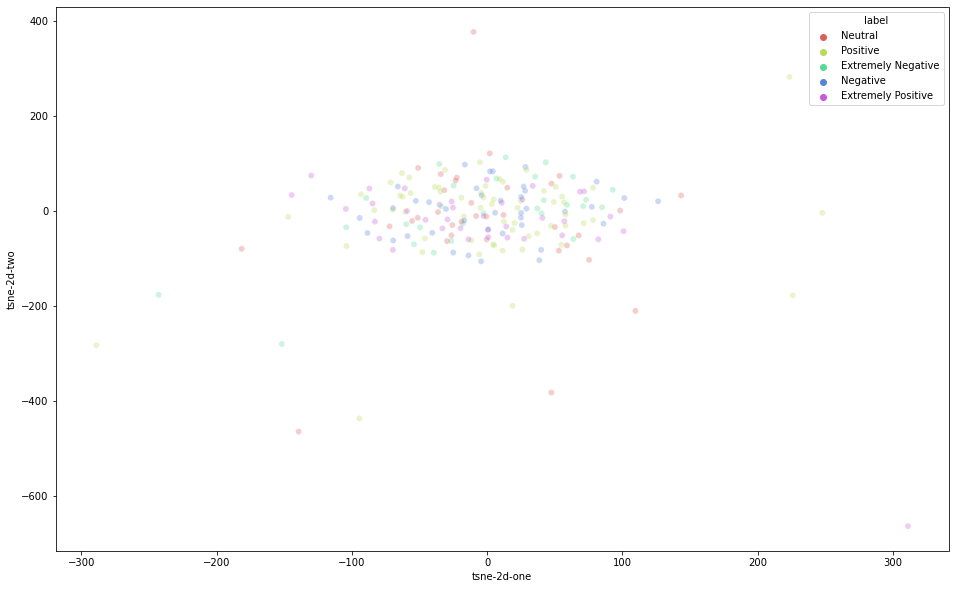

In [21]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

## PCA Representation of the data after embedding

In [22]:
pca = PCA(n_components=3)

In [23]:
df.drop(columns=["tsne-2d-one", "tsne-2d-two", "tsne-2d-three", "label"], inplace=True)

Normalizamos los datos para generar una distribución normal en los datos y asegurar el correcto funcionamiento del PCA

In [24]:
X = StandardScaler().fit_transform(df.to_numpy())

In [25]:
X_d = pca.fit_transform(X)

In [26]:
principalDf = pd.DataFrame(X_d, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf["label"] = y

In [27]:
principalDf

principal component 1  principal component 2  principal component 3  \
0                -6.192466               0.521043              -0.089757   
1                 1.744919               9.422634               8.434875   
2                 8.576117              -0.969041              -0.707299   
3                 0.446285              -3.165140              -4.937239   
4               -11.414151              -5.358826               1.262116   
..                     ...                    ...                    ...   
195               2.379227               1.522260              -3.442214   
196               4.167288               0.643824              -1.338323   
197              -0.319694               0.544677              -1.917801   
198               1.303730              -3.555587              -2.518189   
199               2.832292               3.485404               1.338447   

                  label  
0               Neutral  
1              Positive  
2              Positive  
3              Positive  
4    Extremely Negative  
..                  ...  
195             Neutral  
196  Extremely Positive  
197             Neutral  
198  Extremely Positive  
199            Positive  

[200 rows x 4 columns]

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

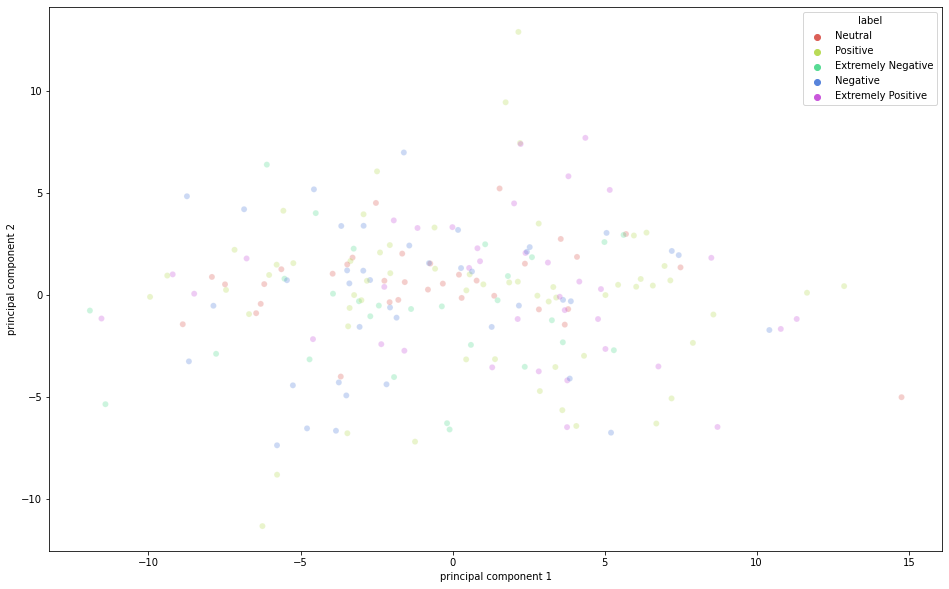

In [28]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=principalDf,
    legend="full",
    alpha=0.3
)

<hr>

In [29]:
import plotly.express as px
fig = px.scatter_3d(principalDf, x='principal component 1', y='principal component 2', z='principal component 3',
              color='label')
fig.show()

<hr>

# K-Means Algorithm <a name="kmeans"></a>

In [30]:
#Number of clusters, number of iterations and early stopping need to be specified beforehand. 
#Number of clusters k 
k  = 5

#Number if iterations till convergence n_iter
n_iter = 150

In [31]:
#Initialize k random centroides. Centroids can not be inizialized on the same point.
def inizialize_centroids(X, k):
    centroids=[] #array with positions of centroids
    temp = []
    i = 0
    while i < k:
        rand = random.randrange(0,X.shape[0]-1) #get an integer between 0 and number of instances
        if rand in temp:
            continue
        else:
            print(f"Points chosen for cluster initialization {rand}") #an instance has been chosen as a centroid
            temp.append(rand) #add that instance to temp to not repeat the same position as centroid
            centroids.append(X[rand]) #add that instance to the centroid
            i = i+1
    return centroids

In [32]:
def assign_cluster(X, centroids, k):
    # Create list of points which are appointed to each cluster
    clusters = [[] for _ in range(k)]

    # Loop through all instances and determine the closest cluster
    for i, j in enumerate(X): 
        closest_centroid = np.argmin(np.sqrt(np.sum((j - centroids) ** 2, axis=1))) #search for the closest distance to a centroid for each instance
        clusters[closest_centroid].append(i) #once we find the closest centroid, append the instance to that centroid's cluster
    return clusters

In [33]:
def determine_new_centroids(k, clusters, X): #once all clusters are determinated, we must recalculate the centroids.
    centroids = np.zeros((k, X.shape[1])) #numpy.zeros creates an array filled with 0s, with the shape of k.
    #print(clusters)
    for i, j in enumerate(clusters): #loops through all clusters
        new_centroid = np.mean(X[j], axis=0) #calculates the mean distance between the instances and centroid of each cluster
        #print(new_centroid)
        centroids[i] = new_centroid #for each clusters assigns the new centroid
    return centroids

In [34]:
def predict_cluster(clusters, X):
    y_pred = np.zeros(X.shape[0]) #create  x=(number of instances) arrays full of 0s

    for i, j in enumerate(clusters):
        for k in j:
            y_pred[k] = i

    return y_pred

In [35]:
def plot_fig(X, y_pred, centroids):
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=30, cmap=plt.cm.RdYlGn)
    plt.scatter(centroids[:, 0], centroids[:,1], s=250, marker='*', c='red', edgecolor='black')
    plt.show()

In [36]:
def dunn_index(X, centroids, clusters):
    index = 0
    distance = 0
    inter_cluster_distance = 999999
    intra_cluster_distance = 0
    current_centroid = []
    to_use_centroids = centroids
    to_use_centroids = to_use_centroids.tolist()
    for i in centroids: #find the smallest distance between centroids
        current_centroid = to_use_centroids.pop(0)
        for j in to_use_centroids: 
            current_centroid = np.array(current_centroid)
            j = np.array(j)
            distance = np.linalg.norm(current_centroid-j)
            if distance < inter_cluster_distance:
                inter_cluster_distance = distance
    
    for number_clusters, centroid in enumerate(centroids):
        for index,instance in enumerate(clusters[number_clusters]):
            actual_centroid = centroids[number_clusters]
            actual_instance = X[instance]
            distance = np.linalg.norm(actual_centroid-actual_instance)
            if distance > intra_cluster_distance:
                intra_cluster_distance = distance
  

    index = inter_cluster_distance / intra_cluster_distance 
    
    return index

In [37]:
def elbow_index(X, clusters, centroids):
    index = 0
    for number_clusters, centroid in enumerate(centroids):
        for index,instance in enumerate(clusters[number_clusters]):
            actual_centroid = centroids[number_clusters]
            actual_instance = X[instance]
            distance = np.linalg.norm(actual_centroid-actual_instance)
            index += distance
    return index

## Make predictions

In [38]:
y_pred = []

In [39]:
centroids = []
def generate_centroids(X,k):
    """ Esta funcion calcula los centroides y devuelve la asignación de cada función"""
    centroids = inizialize_centroids(X, k)
    elbow = []
    for i in range(n_iter):
        print(f"Current iteration {i}")
        clusters = assign_cluster(X, centroids, k)
        prev_centroids = centroids
        centroids = determine_new_centroids(k, clusters, X)

        diff = centroids - prev_centroids


        if not diff.any():
            print(f"Termination criterion satisfied in iteration {i}")
            break
    
            # Get label predictions
    return (predict_cluster(clusters, X),centroids)

In [40]:
y_pred,centroids = generate_centroids(X,5) 

Points chosen for cluster initialization 41
Points chosen for cluster initialization 93
Points chosen for cluster initialization 79
Points chosen for cluster initialization 94
Points chosen for cluster initialization 185
Current iteration 0
Current iteration 1
Current iteration 2
Current iteration 3
Current iteration 4
Current iteration 5
Current iteration 6
Termination criterion satisfied in iteration 6


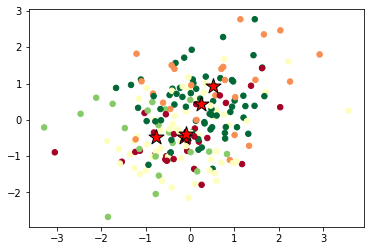

In [41]:
plot_fig(X, y_pred, centroids) # En la imagen salen clusters cuae

La imagen salen clusters de dudosa calidad, siendo asi que la representacion no es la mas adecuada y que los datos no son los optimos. Como demostraremos mas adelante, cada entidad es clasificada correctamente en el cluster adecuado.

In [42]:
y_pred

array([0., 2., 4., 4., 3., 4., 0., 2., 2., 3., 0., 3., 4., 4., 4., 2., 4.,
       2., 2., 4., 3., 2., 2., 2., 3., 2., 2., 0., 2., 3., 4., 0., 4., 0.,
       4., 4., 4., 4., 4., 2., 4., 0., 2., 0., 4., 0., 2., 3., 4., 2., 4.,
       2., 1., 2., 4., 0., 0., 4., 3., 2., 0., 2., 2., 1., 0., 2., 3., 2.,
       4., 4., 1., 2., 4., 1., 2., 1., 4., 2., 4., 2., 4., 4., 3., 3., 2.,
       1., 2., 2., 1., 4., 4., 3., 4., 1., 3., 4., 1., 1., 0., 4., 3., 0.,
       1., 1., 4., 0., 1., 4., 0., 2., 4., 4., 3., 4., 2., 2., 3., 3., 2.,
       4., 2., 4., 2., 1., 2., 0., 4., 2., 0., 2., 1., 1., 2., 1., 3., 2.,
       4., 4., 2., 4., 3., 1., 2., 2., 4., 0., 1., 3., 4., 4., 3., 0., 0.,
       4., 2., 0., 2., 2., 3., 4., 0., 1., 3., 2., 2., 0., 4., 4., 0., 4.,
       0., 4., 1., 4., 2., 0., 1., 4., 2., 2., 2., 2., 4., 4., 2., 4., 0.,
       4., 2., 4., 3., 2., 2., 2., 1., 4., 4., 2., 1., 4.])

Esta es la asignación de cada entidad a su cluster.

<hr>

<div>

# Inference of new instances

In [43]:
model = Doc2Vec.load("doc_2vec_model")

In [73]:
def preprocess(word):
    words  = re.sub('[^A-Za-z ]+', '', word)
    words = words.translate(str.maketrans('', '', string.punctuation))
    words = remove_stopwords(words)
    words = words.lower()
    return words

In [90]:
def assign_label_with_supervised(word):
    preprocessed = preprocess(word)
    moda = []
    words = preprocessed.split(" ")
    infer = model.infer_vector(words)
    similar_documents = model.dv.most_similar([infer], topn = 3)
    for documents in similar_documents:
        moda.append(df_original.iloc[int(documents[0])]["label"])
    return max(set(moda), key=moda.count)


In [75]:
def assing_label_unsupervised(word:str):
    
    preprocessed = preprocess(word)
    distancias = []
    words = preprocessed.split(" ")
    infer = model.infer_vector(words)
    distancias = []
    for centroid in centroids:
        dst = distance.euclidean(infer,centroid)
        distancias.append(dst)
    index_min = np.argmin(distancias)
    print(distancias)
    print(index_min)

In [84]:
def search_similar_doc(word:str):
    preprocessed = preprocess(word)
    words = preprocessed.split(" ")
    infer = model.infer_vector(words)
    similar_documents = model.dv.most_similar([infer], topn = 10)
    text = []
    clase = []
    for documents in similar_documents:
        text.append(df_original.iloc[int(documents[0])]["OriginalTweet"])
        clase.append(y_pred[int(documents[0])])
    df = pd.DataFrame(text,columns=['Tweet Mas Similar'])
    df['Cluster'] = clase
    return df

### Prueba poner cualquier frase y se le asignara un cluster

In [77]:
df_original = pd.read_csv("moritz.csv")
df_original = df_original.head(200)

In [78]:
df_original

0         1         2         3         4         5         6  \
0    0.000383  0.000158 -0.000949  0.000490  0.000481 -0.000549 -0.000422   
1    0.081156  0.012583  0.065316 -0.048686  0.020118  0.000674  0.011840   
2    0.076357  0.042269  0.053119  0.071835  0.035375 -0.043499  0.042177   
3    0.038704  0.027904 -0.016752  0.038551  0.041829 -0.047390 -0.000527   
4   -0.049901 -0.040428 -0.066080  0.037030  0.022905 -0.027634 -0.019163   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.020300  0.025977  0.039574  0.011304  0.000703  0.023311 -0.015562   
196  0.037390  0.013693  0.060709  0.022433 -0.045081 -0.108795  0.011544   
197  0.045157  0.050421  0.032124  0.052485  0.039181 -0.003852  0.000064   
198  0.092874  0.035942  0.074217  0.008098  0.033365  0.020711 -0.024774   
199  0.046270 -0.010605  0.057641  0.015268  0.039404  0.005764  0.032660   

            7         8         9  ...       193       194       195  \
0    0.000336  0.000962 -0.000839  ...  0.000401 -0.000929 -0.000909   
1    0.010894 -0.011872  0.091399  ... -0.104003  0.024765 -0.018291   
2    0.074387  0.079184 -0.004334  ... -0.031691  0.002141 -0.008097   
3    0.024806  0.054844 -0.029237  ... -0.025157  0.053274 -0.092598   
4    0.024063 -0.028400 -0.077838  ...  0.031684  0.017676 -0.052134   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.033986 -0.000837  0.003836  ... -0.051220 -0.000317 -0.027990   
196  0.066346  0.038981  0.018255  ... -0.036315 -0.000800  0.027836   
197  0.018438  0.022132 -0.011504  ... -0.027966  0.022925 -0.031922   
198  0.019222  0.041386  0.016379  ...  0.025596  0.067546 -0.028524   
199  0.077203  0.037647  0.014532  ... -0.059666  0.002961  0.010002   

          196       197       198       199               label  \
0   -0.000839  0.000481 -0.000554 -0.000584             Neutral   
1    0.029533 -0.033234  0.000034  0.010331            Positive   
2   -0.043607 -0.022737  0.024094 -0.021620            Positive   
3   -0.034449  0.005724  0.035747 -0.027550            Positive   
4   -0.032271 -0.062767  0.007405 -0.000203  Extremely Negative   
..        ...       ...       ...       ...                 ...   
195 -0.001611 -0.016581  0.024322 -0.006191             Neutral   
196  0.000260  0.047968  0.052864  0.069476  Extremely Positive   
197 -0.014484 -0.000380  0.031740  0.032061             Neutral   
198 -0.018105 -0.026496 -0.012962  0.001182  Extremely Positive   
199 -0.015650 -0.043606 -0.031099  0.023108            Positive   

                                         OriginalTweet  \
0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1    advice Talk neighbours family exchange phone n...   
2    Coronavirus Australia: Woolworths give elderly...   
3    My food stock one empty... PLEASE, panic, THER...   
4    Me, ready go supermarket #COVID19 outbreak. No...   
..                                                 ...   
195  @SarahHollenbeck @MyClearwater @abcactionnews ...   
196  &gt;@MassGovernor announces $10M loan fund adm...   
197  All pasta, pasta sauce pizza sold grocery stor...   
198  DO NOT PANIC. DO NOT FEAR. Fear Is Mind Killer...   
199  Our retail store closed end March. We keep sta...   

                                    CleanOriginalTweet  
0                            menyrbie phil gaan christ  
1    advice talk neighbour family exchange phone nu...  
2    coronavirus australia woolworth give elderly d...  
3    food stock one empty please panic enough food ...  
4    me ready go supermarket couid outbreak i i par...  
..                                                 ...  
195  sarahhollenbeck clearwater abcactionnews kept ...  
196  it massgovernor announces i loan fund administ...  
197  pasta pasta sauce pizza sold grocery store eve...  
198  panic fear fear mind killer pres working priva...  
199  retail store closed end march keep staff custo...  

[200 rows x 203 columns]

In [82]:
import nltk
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

df_original["OriginalTweet"] = df_original["OriginalTweet"].apply(lambda text:remove_stopwords(text))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
print(assign_label_with_supervised("I love you all, stay safe, love always wins #hearth"))

40447
40659
12266


ValueError: max() arg is an empty sequence

Este metodo utiliza los datos supervisados, por tanto no es lo ideal, es por ello que vamos a utilizar los centroides para asignar un cluster

In [87]:
assing_label_unsupervised("pok oko kok okyoan paper of anything that ive done is to make some")

ValueError: operands could not be broadcast together with shapes (200,) (199,) 

Como se ve, clasifica la instancia en el cluster 4

Esta funcion nos devuelve dos valores, uno siendo la frase con el embedding aplicado y lo otro el cluster asignado por nuestro algoritmo de K-means.

In [88]:
df_pred = search_similar_doc("Toilet paper has some valauable #covid love you")

IndexError: single positional indexer is out-of-bounds

In [89]:
pd.set_option("display.max_colwidth",None)
df_pred.sort_values('Cluster')

NameError: name 'df_pred' is not defined

In [129]:
df1 = df_pred[df_pred["Cluster"] == 0.0].head(10)
df2 = df_pred[df_pred["Cluster"] == 1.0].head(10)
df3 = df_pred[df_pred["Cluster"] == 2.0].head(10)
df4 = df_pred[df_pred["Cluster"] == 3.0].head(10)
df5 = df_pred[df_pred["Cluster"] == 4.0].head(10)
df_pred = pd.concat([df1, df2, df3, df4, df5])
df_pred.head(50)

Tweet Mas Similar  \
76                                                                                                                                                                                                                                                     Part 2 No Toilet Paper DON T Do This   
131                                                                                                                                                                           Understanding the COVID-19 Effect on Online Shopping Behavior https://t.co/fVaIyWi3T6 https://t.co/Z8rAgp7o7J   
182                                                                                                                                                                                                             growth of 53 in response to consumers behaviour Impressive and promising 19   
183                                                                                                                                                                                                                                            surgical masks are not PPE your own guidance   
239                                                                                                                                                                                                                                                                 Lessons learned in 2020   
303                                                                                                                                                             Interesting insight from business experts predicting how consumers will react post #COVID19 \n\n\n\nhttps://t.co/t4ie3VDiaN   
319                                                                                                                                                                                                     Survey: Asian consumer sentiment during the COVID-19 crisis https://t.co/bUaMCD73T2   
387                                                                                                          From March 20 to March 31, @honolulumag is hosting a special collective online shopping event to help support local Hawaii brands affected by COVID-19 https://t.co/GLQdFPeC41   
420                                                                                                                                                                                     Standard supermarket attire. #StaySafeStayHealthy #CoverYourFace #COVID2019 https://t.co/PZ37GZTdyb   
465                                                                                                                                                                                 Effect of COVID-19 on Sri Lankan Consumer Behaviour and the Post-COVID Consumer https://t.co/scxjHWh7lz   
1                                                                                                                                                                                                              Crude oil prices fall to below $26, the lowest since 2003.\n\n\n\n#COVID2019   
4                                                                                                                                                            Crude oil prices fall to $30 as COVID-19 erases gains from oil production cuts https://t.co/XA9laSVqwV https://t.co/hwN4JP1QKC   
5                                                      Thank you to our first responders healthcare workers grocery store employees custodians and all other workers on the frontlines of Your selfless work is very important to the wellbeing of all Bostonians We must practice for them   
7                                                                                                    Please send me or pictures with names of people you think are heroes Can be anyone from nurses doctors supermarket staff police officers health car